In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('../LLCP2023_clean.csv', keep_default_na=False, dtype='category')

In [5]:
label_encoders = {}
for column in df.columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [6]:
X = df.drop(columns=['_MENT14D'])
y = df['_MENT14D']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
model = RandomForestClassifier(random_state=123)

In [9]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

In [10]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovo')

    print("\nModel results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")

    print("\nDetailed classification report:")
    print(classification_report(y_test, y_pred))

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }

In [11]:
metrics = evaluate_model(model, X_test, y_test)


Model results:
Accuracy: 0.6983
F1 Score (weighted): 0.6941
ROC AUC Score: 0.8541

Detailed classification report:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      7472
           1       0.68      0.51      0.58      3548
           2       0.70      0.78      0.74      5070

    accuracy                           0.70     16090
   macro avg       0.69      0.67      0.68     16090
weighted avg       0.70      0.70      0.69     16090


In [12]:
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

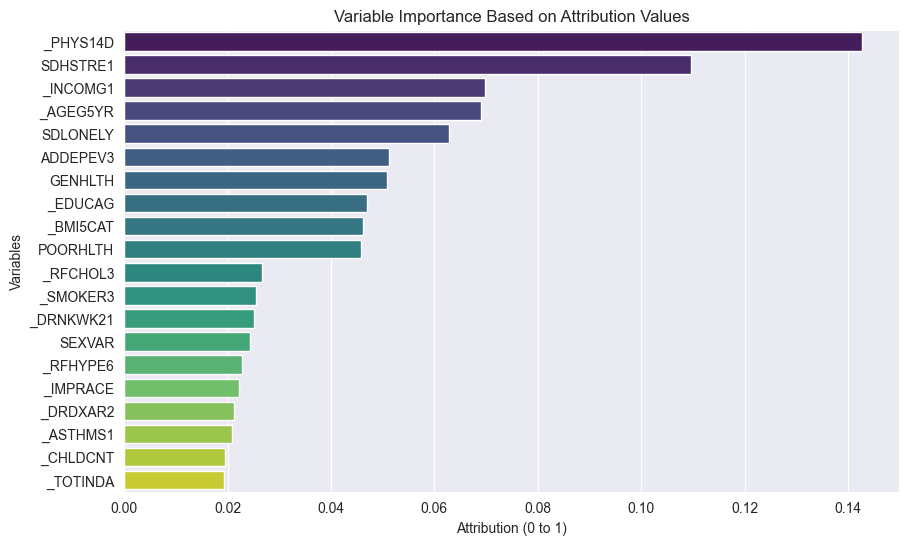

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x='importance',
    y='feature',
    data=importance_df.head(20),
    palette="viridis"
)

plt.title("Variable Importance Based on Attribution Values")
plt.xlabel("Attribution (0 to 1)")
plt.ylabel("Variables")

plt.show()